## 10. Calculate the yield of the single areas N-9.1, N-9.2, N-9.3 without external effects. 
Use the long-term corrected ERA5 data as input. 

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import foxes
import foxes.variables as FV

# Data Paths
lidar_path = 'data/measurements/'
era5_path = 'data/reanalysis/'
turbines_existing_path = 'data/turbine-info/coordinates/existing/'
turbines_planned_future_path = 'data/turbine-info/coordinates/planned_future/'
turbines_planned_in_operation_before_2030_path = 'data/turbine-info/coordinates/planned_in_operation_before_2030/'
turbines_planned_netherlands_path = 'data/turbine-info/coordinates/planned_netherlands/'
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
turbine_power_curves_path = 'data/turbine-info/power_curves/'
external_farms_path = 'data/turbine-info/coordinates/existing_planned/'


# Function to read and extract data from csv files
def read_csv(path):
    data = pd.read_csv(path)
    return data

In [26]:
data = pd.read_csv('LT_corrected_buoy6.csv', index_col=0)
data.index = pd.to_datetime(data.index)

data_2023 = data[data.index.year == 2023]

data_2023

,long-term_WS150,long-term_WD150
time,,
2023-01-01 00:00:00,21.58,225.52
2023-01-01 01:00:00,21.62,231.36
2023-01-01 02:00:00,19.99,231.28
2023-01-01 03:00:00,19.55,232.03
2023-01-01 04:00:00,18.29,230.61
...,...,...
2023-12-31 19:00:00,17.70,179.28
2023-12-31 20:00:00,17.44,184.61
2023-12-31 21:00:00,16.94,187.58


## Task10: Compute Power for N9-1 - 3 separately

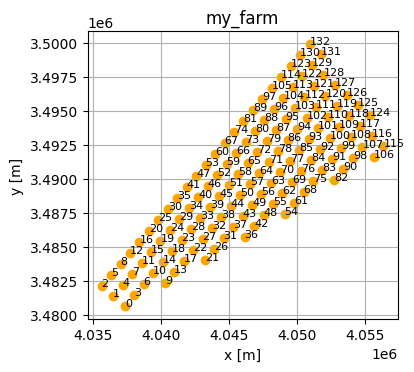

Calculating wind farm power for layout-N-9.1.geom.csv for Wake Model: ['Bastankhah2014_linear']:
[########################################] | 100% Completed | 114.86 ms
[########################################] | 100% Completed | 144.48 s
Efficiency added to farm results


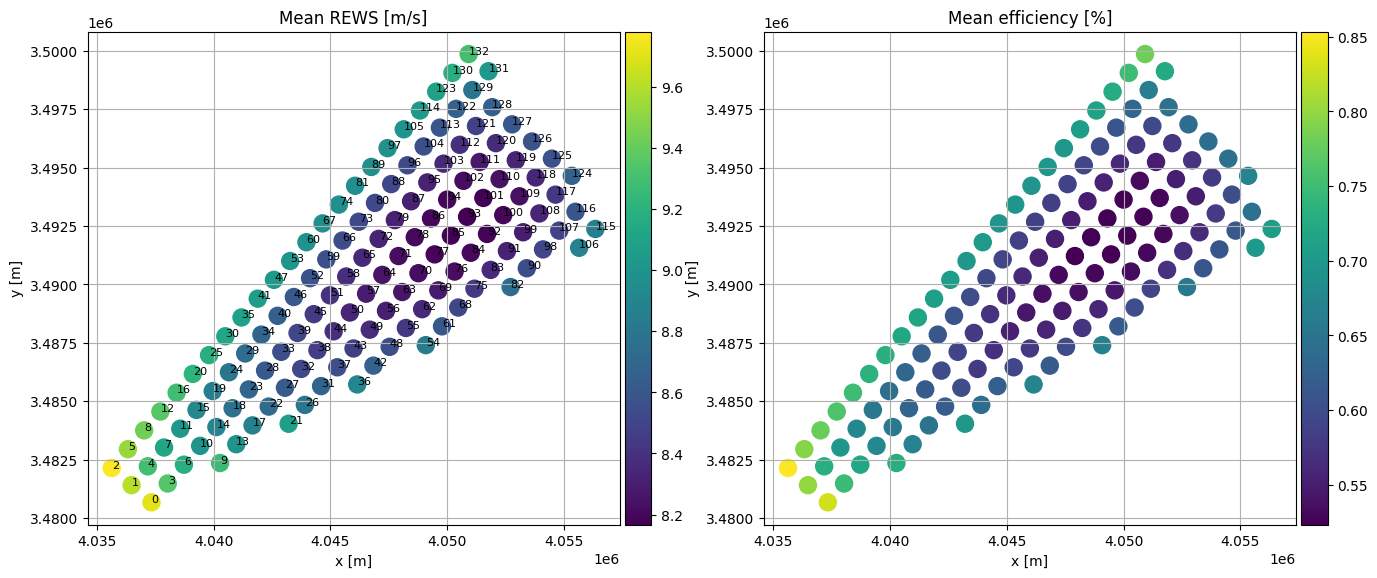

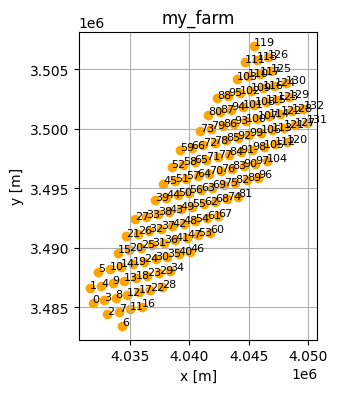

Calculating wind farm power for layout-N-9.2.geom.csv for Wake Model: ['Bastankhah2014_linear']:
[########################################] | 100% Completed | 111.09 ms
[########################################] | 100% Completed | 153.50 s
Efficiency added to farm results


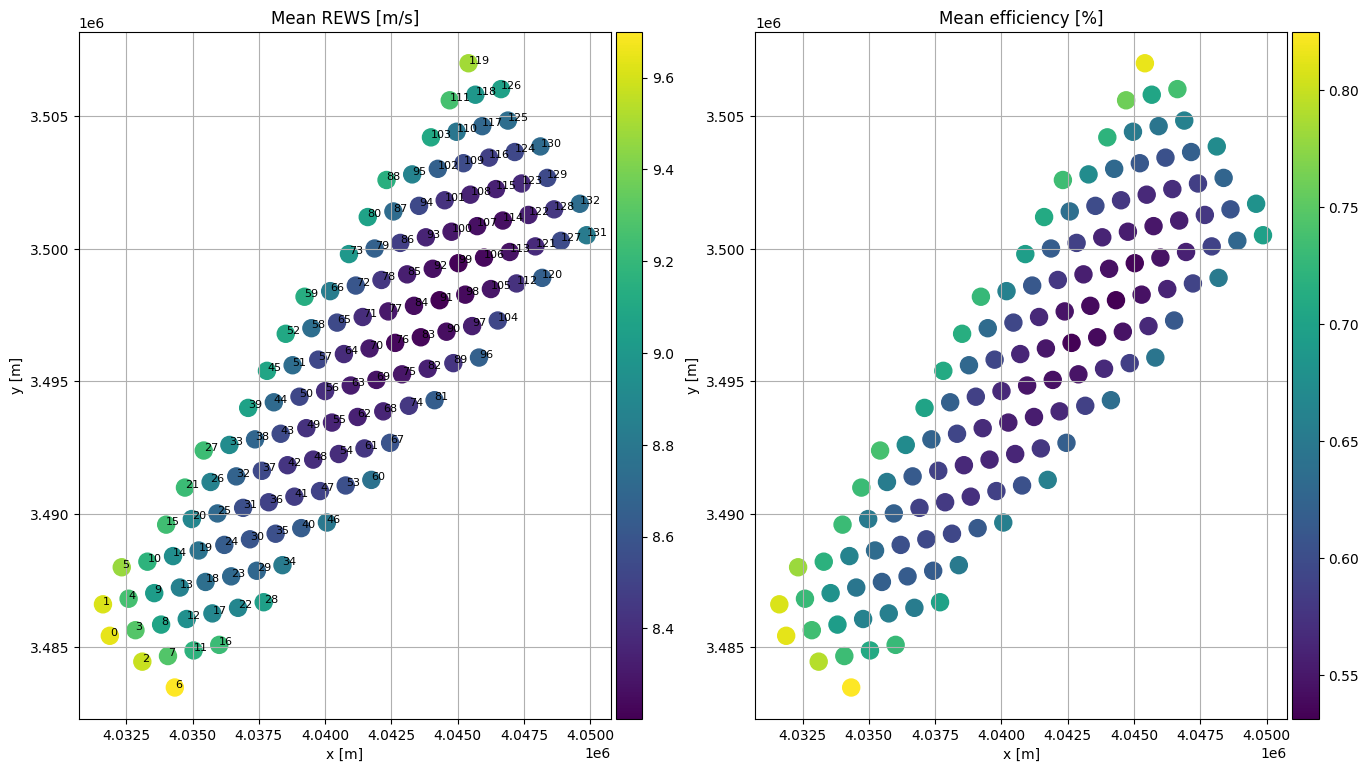

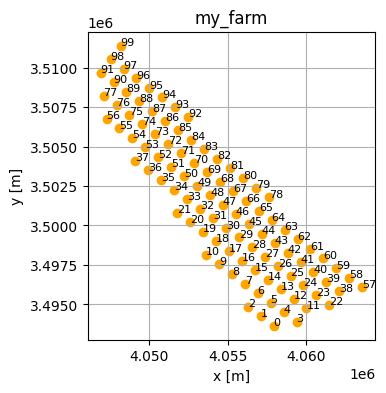

Calculating wind farm power for layout-N-9.3.geom.csv for Wake Model: ['Bastankhah2014_linear']:
[########################################] | 100% Completed | 108.93 ms
[########################################] | 100% Completed | 91.84 s
Efficiency added to farm results


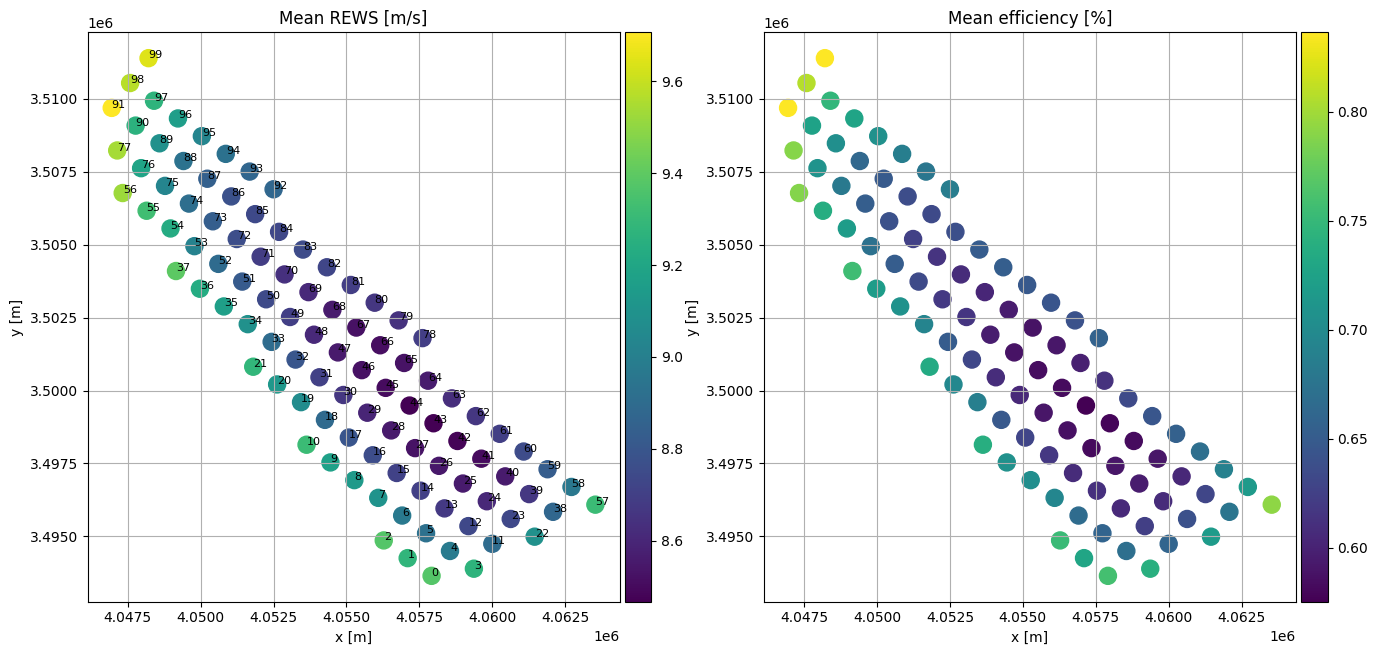

In [38]:
from Foxes_Farm_Power import Foxes_Farm_Power

###-------------------------------------add Turbine Layouts----------------------------------###
# create 3 Dataframes for Turbine Layouts
current_path =  turbines_area_of_interest_path                           # path .csv's
turb_files = os.listdir(turbines_area_of_interest_path)
Turb_dfs = [(read_csv(current_path + file),file) for file in turb_files]

#Load the coordinates of geo_layout
Areas = ['N-9.1','N-9.2','N-9.3'] 
Layout_Path = ["NoWake_Layout_" + area + ".csv" for area in Areas]
Layout_dfs = [read_csv(file) for file in Layout_Path]  

#replace the coordinates of the turb_dfs with coordinates geolayout
for i, (turb_df, filename) in enumerate(Turb_dfs):
    layout_df = Layout_dfs[i]
    turb_df[['x', 'y']] = layout_df[['x', 'y']]
    Turb_dfs[i] = (turb_df, filename)

###----------------------------------------Add States-----------------------------------------###
States = foxes.input.states.Timeseries(                      
    data_source = data_2023 ,                                        
    output_vars = [FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col =     {FV.WS: "long-term_WS150", FV.WD: "long-term_WD150", FV.TI: "time"}, 
    fixed_vars =  {FV.RHO: 1.225, FV.TI: 0.05},                  
    )

###--------------------------------------Important Parameters---------------------------------------###
Parameters = dict(                              # passed to the foxes.algorithms.Downwind()
    TType         = "IEA15MW",                  #"NREL5MW","IEA15MW"
    rotor_model   = "centre",
    wake_models   = ["Bastankhah2014_linear"],
    partial_wakes = None,
    )

###--------------------------------------compute farm results--------------------------------------###
Farm_Results = []
for Farm in Turb_dfs:
    Farm_Results.append(Foxes_Farm_Power(Farm,States,Parameters))

In [40]:
results_N91 = Farm_Results[0][0]
results_N91_turbines = Farm_Results[0][1]
results_N92 = Farm_Results[1][0]
results_N92_turbines = Farm_Results[1][1]
results_N93 = Farm_Results[2][0]
results_N93_turbines = Farm_Results[2][1]

pd.options.display.float_format = '{:.2f}'.format
print(f'Results N91 only internal wakes: {results_N91}')
# print(f'Results N91 Turbines: {results_N91_turbines}')
print(f'Results N92 only internal wakes: {results_N92}')
# print(f'Results N92 Turbines: {results_N92_turbines}')
print(f'Results N93only internal wakes: {results_N93}')
# print(f'Results N93 Turbines: {results_N93_turbines}')


Results N91 only internal wakes:                        Farm power [MW]  Farm ambient power [MW]  \
layout-N-9.1.geom.csv           938.00                  1257.62   

                       Farm efficiency [%]  Annual farm yield [TWh]  
layout-N-9.1.geom.csv                74.58                     8.22  
Results N92 only internal wakes:                        Farm power [MW]  Farm ambient power [MW]  \
layout-N-9.2.geom.csv           940.73                  1257.62   

                       Farm efficiency [%]  Annual farm yield [TWh]  
layout-N-9.2.geom.csv                74.80                     8.24  
Results N93only internal wakes:                        Farm power [MW]  Farm ambient power [MW]  \
layout-N-9.3.geom.csv           733.84                   945.58   

                       Farm efficiency [%]  Annual farm yield [TWh]  
layout-N-9.3.geom.csv                77.61                     6.43  


In [112]:
# Function to group by time: year for now and calculate the mean
def group_month_and_calc_mean(df):
    df = df.copy()  # Ensure working with a copy of the DataFrame
    df.index = pd.to_datetime(df.index)
    df.loc[:, 'year'] = df.index.year  # Use .loc to avoid the SettingWithCopyWarning
    df_month_mean = df.groupby('year').mean()
    return df_month_mean

df_month_mean = group_month_and_calc_mean(data_2023)
df_month_mean

,long-term_WS150,long-term_WD150
year,,
2023,10.24,206.50


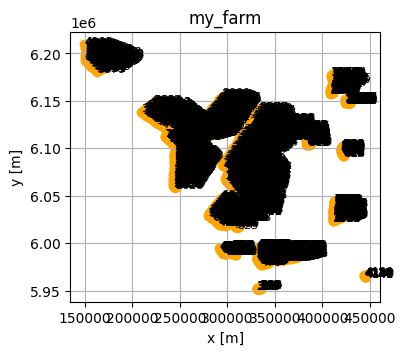

Calculating wind farm power for Combined_Cluster1 for Wake Model: ['Bastankhah2014_linear']:
[########################################] | 100% Completed | 105.40 ms
[########################################] | 100% Completed | 25.20 s
Efficiency added to farm results


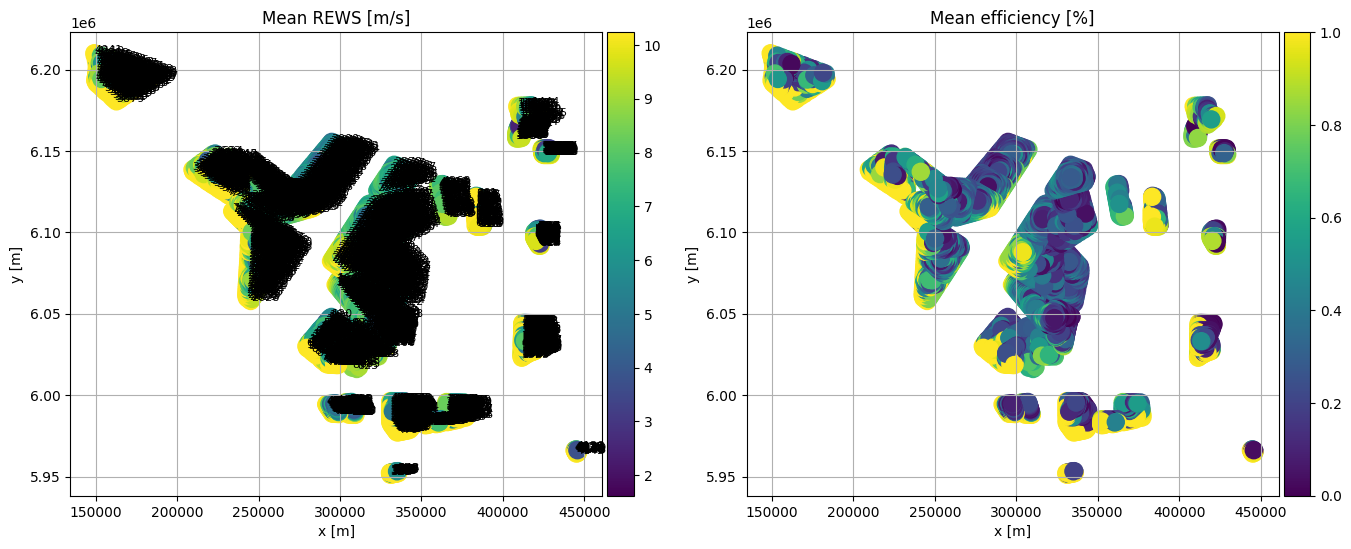

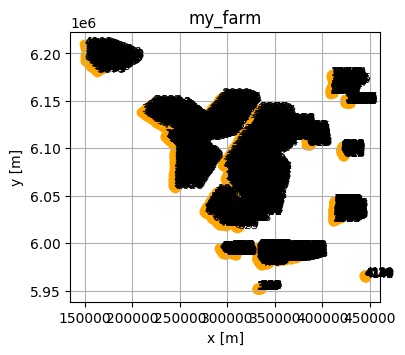

Calculating wind farm power for Combined_Cluster2 for Wake Model: ['Bastankhah2014_linear']:
[########################################] | 100% Completed | 103.74 ms
[########################################] | 100% Completed | 24.34 s
Efficiency added to farm results


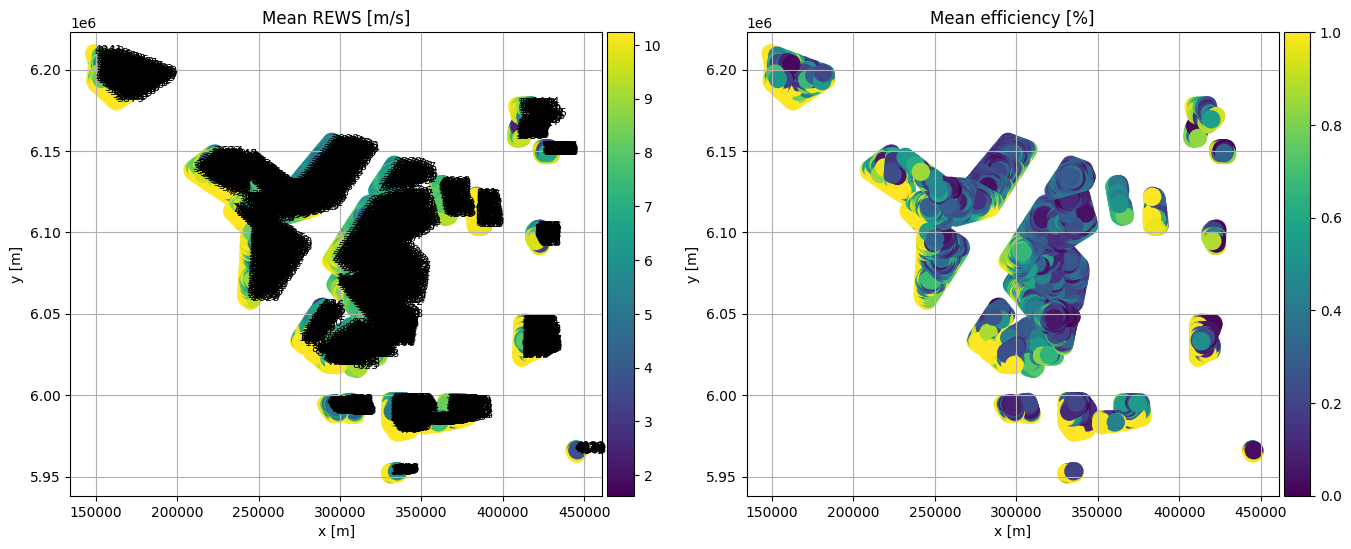

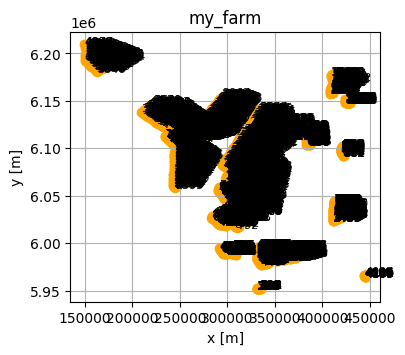

Calculating wind farm power for Combined_Cluster3 for Wake Model: ['Bastankhah2014_linear']:
[########################################] | 100% Completed | 105.35 ms
[########################################] | 100% Completed | 24.02 s
Efficiency added to farm results


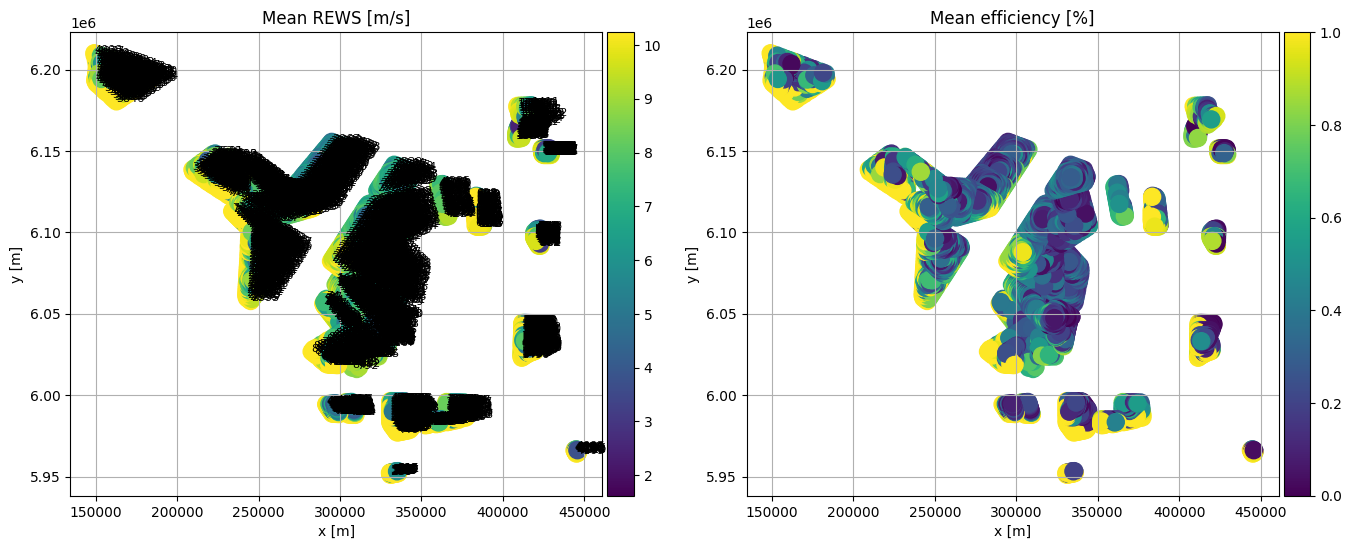

In [120]:
# Paths
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
external_farms_path = 'data/turbine-info/coordinates/existing_planned/'

# Read internal turbine layout files
internal_files = os.listdir(turbines_area_of_interest_path) # List all files in the directory
Turb_dfs = [pd.read_csv(turbines_area_of_interest_path + file) for file in internal_files]

# Read external turbine layout files
external_files = os.listdir(external_farms_path)
external_dfs = [pd.read_csv(external_farms_path + file) for file in external_files]
external_combined_df = pd.concat(external_dfs, ignore_index=True)

# Combine internal and external layouts for wake effect calculation
Combined_Turb_dfs = []
for i in range(len(Turb_dfs)):
    combined_df = pd.concat([Turb_dfs[i], external_combined_df], ignore_index=True)
    Combined_Turb_dfs.append((combined_df, f"Combined_Cluster{i+1}"))

# Define States using a valid data source
States = foxes.input.states.Timeseries(
    data_source= df_month_mean,
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col={FV.WS: "long-term_WS150", FV.WD: "long-term_WD150", FV.TI: "time"},
    fixed_vars={FV.RHO: 1.225, FV.TI: 0.05},
)

# Define Parameters
Parameters = {
    'TType': "IEA15MW",
    'rotor_model': "centre",
    'wake_models': ["Bastankhah2014_linear"],
    'partial_wakes': None,
}

# Calculate the farm results with wake effects
combined_results = []
for Combined_Turb_df in Combined_Turb_dfs:
    result = Foxes_Farm_Power(Combined_Turb_df, States, Parameters)
    combined_results.append(result)


In [176]:
# Cluster labels
cluster_labels = ['N9_1', 'N9_2', 'N9_3']

# Load total farm yield without wakes
total_farmyield_nowakes = pd.read_csv('total_farmyield_nowakes.csv')
yield_no_wakes = [total_farmyield_nowakes.loc[0, f'yield_{label}'] for label in cluster_labels]

# Initialize results list
results = []

# Process and print the results
for i, combined_result in enumerate(combined_results):
    summary_results, turbine_results = combined_result
    
    # Extract the results for the farm of interest (Turb_df)
    matched_turbines = turbine_results.merge(Turb_dfs[i], left_on=['X', 'Y'], right_on=['x', 'y'])
    matched_turbines = matched_turbines.drop(['x', 'y'], axis=1)
    
    # Calculate the annual farm yield
    farm_yield = (matched_turbines['YLD'].sum()) / 1000  # Convert to TWh
    
    results.append({
        'Cluster': cluster_labels[i],
        'Scenario': 'internal + external wakes',
        'Yield (TWh)': farm_yield
    })

# Reset results for internal wakes
results_N91_reset = results_N91.reset_index(drop=True)
results_N92_reset = results_N92.reset_index(drop=True)
results_N93_reset = results_N93.reset_index(drop=True)

# Extract yields for internal wakes
yield_internal_wakes = [
    results_N91_reset.loc[0, 'Annual farm yield [TWh]'],
    results_N92_reset.loc[0, 'Annual farm yield [TWh]'],
    results_N93_reset.loc[0, 'Annual farm yield [TWh]']
]

# Add yields to results list
for i, yield_value in enumerate(yield_internal_wakes):
    results.append({
        'Cluster': f'N9_{i+1}',
        'Scenario': 'internal wakes',
        'Yield (TWh)': yield_value
    })

for i, yield_value in enumerate(yield_no_wakes):
    results.append({
        'Cluster': f'N9_{i+1}',
        'Scenario': 'no wakes',
        'Yield (TWh)': yield_value
    })

# Create a dictionary for no wakes yields
no_wakes_dict = {f'N9_{i+1}': yield_no_wakes[i] for i in range(len(cluster_labels))}

# Calculate percentages and update results
for result in results:
    cluster = result['Cluster']
    scenario = result['Scenario']
    yield_value = result['Yield (TWh)']
    if scenario != 'no wakes':
        no_wakes_yield = no_wakes_dict[cluster]
        percentage = (yield_value / no_wakes_yield) * 100
        result['Percentage of no wakes'] = percentage
    else:
        result['Percentage of no wakes'] = 100

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save results to CSV
results_df.to_csv('farm_yields.csv', index=False)

# Print all results
for result in results:
    print(f"{result['Cluster']} - {result['Scenario']}: {result['Yield (TWh)']:.2f} TWh ({result['Percentage of no wakes']:.2f}%)")


N9_1 - internal + external wakes: 5.59 TWh (49.29%)
N9_2 - internal + external wakes: 6.22 TWh (54.88%)
N9_3 - internal + external wakes: 5.90 TWh (69.22%)
N9_1 - internal wakes: 8.22 TWh (72.46%)
N9_2 - internal wakes: 8.24 TWh (72.67%)
N9_3 - internal wakes: 6.43 TWh (75.40%)
N9_1 - no wakes: 11.34 TWh (100.00%)
N9_2 - no wakes: 11.34 TWh (100.00%)
N9_3 - no wakes: 8.53 TWh (100.00%)


In [177]:
results_df

,Cluster,Scenario,Yield (TWh),Percentage of no wakes
0,N9_1,internal + external wakes,5.59,49.29
1,N9_2,internal + external wakes,6.22,54.88
2,N9_3,internal + external wakes,5.90,69.22
3,N9_1,internal wakes,8.22,72.46
4,N9_2,internal wakes,8.24,72.67
5,N9_3,internal wakes,6.43,75.40
6,N9_1,no wakes,11.34,100.00
7,N9_2,no wakes,11.34,100.00
8,N9_3,no wakes,8.53,100.00
